# Step 2: Feature Engineering

According to [Wikipedia, Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is the process of using domain knowledge of the data to create features that make machine learning algorithms work. Feature engineering is fundamental to the application of machine learning, and is both difficult and expensive. 

This Feature engineering notebook will load the data sets created in the **Data Ingestion** notebook (`Code/1_data_ingestion.ipynb`) from an Azure storage container and combine them to create a single data set of features (variables) that can be used to infer a machines's health condition over time. The notebook steps through several feature engineering and labeling methods to create this data set for use in our predictive maintenance machine learning solution.

**Note:** This notebook will take about 20-30 minutes to execute all cells, depending on the compute configuration you have setup.

In [2]:
## Setup our environment by importing required libraries
import time

# Read csv file from URL directly
import pandas as pd
import pyspark.sql.functions as F
# For creating some preliminary EDA plots.
# %matplotlib inline
from ggplot import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, round
from pyspark.sql.functions import datediff
from pyspark.sql.types import DoubleType
from pyspark.sql.window import Window

# Time the notebook execution. 
# This will only make sense if you "Run all cells"
tic = time.time()

spark = SparkSession.builder.getOrCreate()

# These file names detail which blob each files is stored under. 
MACH_DATA = 'machines_files'
MAINT_DATA = 'maint_files'
ERROR_DATA = 'errors_files'
TELEMETRY_DATA = 'telemetry_files'
FAILURE_DATA = 'failure_files'


In [3]:
dbutils.widgets.removeAll()
dbutils.widgets.text("FEATURES_TABLE","training_data")

dbutils.widgets.text("Start_Date", '2000-01-01')

dbutils.widgets.text("zEnd_Date", '2015-10-30')

## Feature engineering 

Our feature engineering will combine the different data sources together to create a single data set of features (variables) that can be used to infer a machines's health condition over time. The ultimate goal is to generate a single record for each time unit within each asset. The record combines features and labels to be fed into the machine learning algorithm.

Predictive maintenance take historical data, marked with a timestamp, to predict current health of a component and the probability of failure within some future window of time. These problems can be characterised as a _classification method_ involving _time series_ data. Time series, since we want to use historical observations to predict what will happen in the future. Classification, because we classify the future as having a probability of failure.

### Lag features

There are many ways of creating features from the time series data. We start by dividing the duration of data collection into time units where each record belongs to a single point in time for each asset. The measurement unit for is in fact arbitrary. Time can be in seconds, minutes, hours, days, or months, or it can be measured in cycles, miles or transactions. The measurement choice is typically specific to the use case domain.

Additionally, the time unit does not have to be the same as the frequency of data collection. For example, if temperature values were being collected every 10 seconds, picking a time unit of 10 seconds for analysis may inflate the number of examples without providing any additional information if the temperature changes slowly. A better strategy may be to average the temperature over a longer time horizon which might better capture variations that contribute to the target outcome.

Once we set the frequency of observations, we want to look for trends within measures, over time, in order to predict performance degradation, which we would like to connect to how likely a component will fail. We create features for these trends within each record using time lags over previous observations to check for these performance changes. The lag window size $W$ is a hyper parameter that we can optimize. The following figures indicate a _rolling aggregate window_ strategy for averaging a measure $t_i$ over a window $W = 3$ previous observations.

![Rolling windows](https://github.com/Azure/MachineLearningSamples-PredictiveMaintenance/images/rolling-aggregate-features.png )

We are note constrained to averages, we can roll aggregates over counts, average, the standard deviation, outliers based on standard deviations, CUSUM measures, minimum and maximum values for the window. 

We could also use a tumbling window approach, if we were interested in a different time window measure than the frequncy of the observations. For example, we might have obersvations evert 6 or 12 hours, but want to create features aligned on a day or week basis.  
![Tumbling windows](../images/tumbling-aggregate-features.png)

In the following sections, we will build our features using only a rolling strategy to demonstrate the process. We align our data, and then build features along those normalized observations times. We start with the telemetry data.

## Telemetry features

Because the telemetry data set is the largest time series data we have, we start feature engineering here. The telemetry data has 8761000 hourly observations for out 1000 machines. We can improve the model performance by aligning our data by aggregating average sensor measures on a tumbling 12 hour window. In this case we replace the raw data with the tumbling window data, reducing the sensor data to 731000 observations. This will directly reduce the computaton time required to do the feature engineering, labeling and modeling required for our solution.    

Once we have the reduced data, we set up our lag features by compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over time. 

The following code blocks alignes the data on 12 hour observations and calculates a rolling mean and standard deviation of the telemetry data over the last 12, 24 and 36 hour lags.

In [6]:
qryStr = "SELECT * FROM "+ TELEMETRY_DATA + " WHERE datetime <= '" + dbutils.widgets.get("zEnd_Date") + "' AND datetime > '" + dbutils.widgets.get("Start_Date") + "'"
print(qryStr)
telemetry = spark.sql(qryStr)

# rolling mean and standard deviation
# Temporary storage for rolling means
tel_mean = telemetry

# Which features are we interested in telemetry data set
rolling_features = ['volt','rotate', 'pressure', 'vibration']
      
# n hours = n * 3600 seconds  
time_val = 12 * 3600

# Choose the time_val hour timestamps to align the data
# dt_truncated looks at the column named "datetime" in the current data set.
# remember that Spark is lazy... this doesn't execute until it is in a withColumn statement.
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

SELECT * FROM telemetry_files WHERE datetime <= '2018-10-30' AND datetime > '2015-11-15'

In [7]:
# We choose windows for our rolling windows 12hrs, 24 hrs and 36 hrs
lags = [12, 24, 36]

# align the data
for lag_n in lags:
    wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-lag_n, 0)
    for col_name in rolling_features:
        tel_mean = tel_mean.withColumn(col_name+'_rollingmean_'+str(lag_n), 
                                       F.avg(col(col_name)).over(wSpec))
        tel_mean = tel_mean.withColumn(col_name+'_rollingstd_'+str(lag_n), 
                                       F.stddev(col(col_name)).over(wSpec))

# Calculate lag values...
telemetry_feat = (tel_mean.withColumn("dt_truncated", dt_truncated)
                  .drop('volt', 'rotate', 'pressure', 'vibration')
                  .fillna(0)
                  .groupBy("machineID","dt_truncated")
                  .agg(F.mean('volt_rollingmean_12').alias('volt_rollingmean_12'),
                       F.mean('rotate_rollingmean_12').alias('rotate_rollingmean_12'), 
                       F.mean('pressure_rollingmean_12').alias('pressure_rollingmean_12'), 
                       F.mean('vibration_rollingmean_12').alias('vibration_rollingmean_12'), 
                       F.mean('volt_rollingmean_24').alias('volt_rollingmean_24'),
                       F.mean('rotate_rollingmean_24').alias('rotate_rollingmean_24'), 
                       F.mean('pressure_rollingmean_24').alias('pressure_rollingmean_24'), 
                       F.mean('vibration_rollingmean_24').alias('vibration_rollingmean_24'),
                       F.mean('volt_rollingmean_36').alias('volt_rollingmean_36'),
                       F.mean('vibration_rollingmean_36').alias('vibration_rollingmean_36'),
                       F.mean('rotate_rollingmean_36').alias('rotate_rollingmean_36'), 
                       F.mean('pressure_rollingmean_36').alias('pressure_rollingmean_36'), 
                       F.stddev('volt_rollingstd_12').alias('volt_rollingstd_12'),
                       F.stddev('rotate_rollingstd_12').alias('rotate_rollingstd_12'), 
                       F.stddev('pressure_rollingstd_12').alias('pressure_rollingstd_12'), 
                       F.stddev('vibration_rollingstd_12').alias('vibration_rollingstd_12'), 
                       F.stddev('volt_rollingstd_24').alias('volt_rollingstd_24'),
                       F.stddev('rotate_rollingstd_24').alias('rotate_rollingstd_24'), 
                       F.stddev('pressure_rollingstd_24').alias('pressure_rollingstd_24'), 
                       F.stddev('vibration_rollingstd_24').alias('vibration_rollingstd_24'),
                       F.stddev('volt_rollingstd_36').alias('volt_rollingstd_36'),
                       F.stddev('rotate_rollingstd_36').alias('rotate_rollingstd_36'), 
                       F.stddev('pressure_rollingstd_36').alias('pressure_rollingstd_36'), 
                       F.stddev('vibration_rollingstd_36').alias('vibration_rollingstd_36'), ))

print(telemetry_feat.count())
telemetry_feat.where((col("machineID") == 1)).limit(10).toPandas().head(10)

96000
 Out[ 24 ]: 
 machineID dt_truncated volt_rollingmean_12 rotate_rollingmean_12 \
0 1 2015-12-17 00:00:00 169.167041 455.734514 
1 1 2015-12-11 12:00:00 173.352547 448.775731 
2 1 2015-12-19 12:00:00 164.843162 429.836585 
3 1 2015-12-13 00:00:00 177.011104 452.701917 
4 1 2015-12-18 12:00:00 171.289157 439.045915 
5 1 2015-11-16 00:00:00 186.502218 459.974033 
6 1 2015-11-24 12:00:00 169.476617 442.790670 
7 1 2015-12-26 00:00:00 166.870879 448.473171 
8 1 2015-12-19 00:00:00 167.576134 450.898107 
9 1 2015-12-25 00:00:00 169.133148 429.630218 

 pressure_rollingmean_12 vibration_rollingmean_12 volt_rollingmean_24 \
0 98.842483 39.104152 171.370731 
1 101.412437 39.027765 171.292002 
2 101.942104 39.061395 166.209648 
3 121.725091 39.525528 175.988290 
4 101.394671 40.717717 169.596060 
5 100.911766 38.742478 187.954851 
6 97.963717 39.549298 169.883607 
7 101.023943 39.137202 167.624520 
8 101.048209 40.104845 169.432646 
9 100.524888 38.171276 173.183556 

 rotate_rollingmean_24 pressure_rollingmean_24 vibration_rollingmean_24 \
0 452.306194 98.278780 42.471398 
1 444.774327 101.879997 39.588702 
2 440.367346 101.495157 39.583120 
3 442.301466 121.719897 39.458416 
4 451.309115 103.295375 41.442660 
5 459.758182 100.385110 39.830120 
6 449.572184 98.037667 39.347424 
7 443.226707 100.029503 39.462094 
8 444.972011 101.221440 40.411281 
9 433.920872 100.032742 38.363267 

 ... pressure_rollingstd_12 vibration_rollingstd_12 \
0 ... 1.031176 0.801300 
1 ... 1.520909 0.524005 
2 ... 0.649582 0.714251 
3 ... 1.477395 0.144161 
4 ... 0.792657 0.987661 
5 ... 0.467253 0.383934 
6 ... 1.440137 0.411173 
7 ... 0.381593 0.986539 
8 ... 1.285195 0.433688 
9 ... 0.886448 0.860949 

 volt_rollingstd_24 rotate_rollingstd_24 pressure_rollingstd_24 \
0 0.874356 2.523363 1.116471 
1 0.491613 2.037811 0.483161 
2 0.474559 2.328047 0.320191 
3 0.244662 3.673056 0.299022 
4 0.615732 1.524631 0.774910 
5 0.587934 1.874871 0.371892 
6 0.750819 1.866814 0.893959 
7 0.522484 6.129426 0.356957 
8 1.842796 1.817469 0.977031 
9 0.703096 2.584679 0.746109 

 vibration_rollingstd_24 volt_rollingstd_36 rotate_rollingstd_36 \
0 0.800095 0.505470 2.272075 
1 0.292491 0.961163 2.095341 
2 0.204196 0.249691 1.100880 
3 0.152636 0.204111 1.320518 
4 0.277231 0.849947 0.893086 
5 0.265864 0.560079 1.651064 
6 0.230247 0.220048 2.173188 
7 0.276796 0.440065 1.785638 
8 0.549482 1.176273 1.265127 
9 0.220573 0.813799 2.336047 

 pressure_rollingstd_36 vibration_rollingstd_36 
0 0.260917 0.302917 
1 0.306276 0.286464 
2 0.402517 0.314121 
3 1.432209 0.123397 
4 0.371480 0.216065 
5 0.210456 0.170387 
6 0.352328 0.124771 
7 0.148917 0.291837 
8 0.342829 0.217780 
9 0.322749 0.225834 

[10 rows x 26 columns]

## Errors features

Like telemetry data, errors come with timestamps. An important difference is that the error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type within a lag window. 

Again, we align the error counts data by tumbling over the 12 hour window using a join with telemetry data.

In [9]:
errors = spark.sql("SELECT * FROM " + ERROR_DATA + " WHERE datetime <= '" + dbutils.widgets.get("zEnd_Date") + "' AND datetime > '" + dbutils.widgets.get("Start_Date") + "'")

# create a column for each errorID 
error_ind = (errors.groupBy("machineID","datetime","errorID").pivot('errorID')
             .agg(F.count('machineID').alias('dummy')).drop('errorID').fillna(0)
             .groupBy("machineID","datetime")
             .agg(F.sum('error1').alias('error1sum'), 
                  F.sum('error2').alias('error2sum'), 
                  F.sum('error3').alias('error3sum'), 
                  F.sum('error4').alias('error4sum'), 
                  F.sum('error5').alias('error5sum')))

# join the telemetry data with errors
error_count = (telemetry.join(error_ind, 
                              ((telemetry['machineID'] == error_ind['machineID']) 
                               & (telemetry['datetime'] == error_ind['datetime'])), "left")
               .drop('volt', 'rotate', 'pressure', 'vibration')
               .drop(error_ind.machineID).drop(error_ind.datetime)
               .fillna(0))

error_features = ['error1sum','error2sum', 'error3sum', 'error4sum', 'error5sum']

wSpec = Window.partitionBy('machineID').orderBy('datetime').rowsBetween(1-24, 0)
for col_name in error_features:
    # We're only interested in the erros in the previous 24 hours.
    error_count = error_count.withColumn(col_name+'_rollingmean_24', 
                                         F.avg(col(col_name)).over(wSpec))

error_feat = (error_count.withColumn("dt_truncated", dt_truncated)
              .drop('error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum').fillna(0)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('error1sum_rollingmean_24').alias('error1sum_rollingmean_24'), 
                   F.mean('error2sum_rollingmean_24').alias('error2sum_rollingmean_24'), 
                   F.mean('error3sum_rollingmean_24').alias('error3sum_rollingmean_24'), 
                   F.mean('error4sum_rollingmean_24').alias('error4sum_rollingmean_24'), 
                   F.mean('error5sum_rollingmean_24').alias('error5sum_rollingmean_24')))

print(error_feat.count())
error_feat.limit(10).toPandas().head(10)

96000
 Out[ 25 ]: 
 machineID dt_truncated error1sum_rollingmean_24 \
0 474 2015-12-06 12:00:00 0.0 
1 222 2015-11-28 00:00:00 0.0 
2 270 2015-12-13 12:00:00 0.0 
3 293 2015-11-18 00:00:00 0.0 
4 270 2015-12-18 00:00:00 0.0 
5 551 2015-11-21 12:00:00 0.0 
6 830 2015-11-18 12:00:00 0.0 
7 406 2015-12-05 12:00:00 0.0 
8 638 2015-12-08 00:00:00 0.0 
9 876 2015-12-12 12:00:00 0.0 

 error2sum_rollingmean_24 error3sum_rollingmean_24 \
0 0.0 0.0 
1 0.0 0.0 
2 0.0 0.0 
3 0.0 0.0 
4 0.0 0.0 
5 0.0 0.0 
6 0.0 0.0 
7 0.0 0.0 
8 0.0 0.0 
9 0.0 0.0 

 error4sum_rollingmean_24 error5sum_rollingmean_24 
0 0.0 0.0 
1 0.0 0.0 
2 0.0 0.0 
3 0.0 0.0 
4 0.0 0.0 
5 0.0 0.0 
6 0.0 0.0 
7 0.0 0.0 
8 0.0 0.0 
9 0.0 0.0

## Days since last replacement from maintenance 

A crucial data set in this example is the use of maintenance records, which contain the information regarding component replacement. Possible features from this data set can be the number of replacements of each component over time or to calculate how long it has been since a component has been replaced. Replacement time is expected to correlate better with component failures since the longer a component is used, the more degradation would be expected.

As a side note, creating lagging features from maintenance data is not straight forward. This type of ad-hoc feature engineering is very common in predictive maintenance as domain knowledge plays a crucial role in understanding the predictors of a failure problem. In the following code blocks, the days since last component replacement are calculated for each component from the maintenance data. We start by counting the component replacements for the set of machines.

In [11]:
maint = spark.sql("SELECT * FROM " + MAINT_DATA + " WHERE datetime <= '" + dbutils.widgets.get("zEnd_Date") + "' AND datetime > '" + dbutils.widgets.get("Start_Date") + "'")

# create a column for each component replacement
maint_replace = (maint.groupBy("machineID","datetime","comp").pivot('comp')
                 .agg(F.count('machineID').alias('dummy')).fillna(0)
                 .groupBy("machineID","datetime")
                 .agg(F.sum('comp1').alias('comp1sum'), 
                      F.sum('comp2').alias('comp2sum'), 
                      F.sum('comp3').alias('comp3sum'),
                      F.sum('comp4').alias('comp4sum')))

maint_replace = maint_replace.withColumnRenamed('datetime','datetime_maint')

print(maint_replace.count())
maint_replace.limit(10).toPandas().head(10)

2861
 Out[ 26 ]: 
 machineID datetime_maint comp1sum comp2sum comp3sum comp4sum
0 548 2015-12-07 06:00:00 0 0 1 0
1 827 2015-12-28 06:00:00 0 1 0 0
2 681 2015-11-25 06:00:00 0 1 0 0
3 816 2015-11-17 06:00:00 0 1 0 0
4 322 2015-11-27 06:00:00 1 0 1 0
5 382 2015-11-22 06:00:00 1 0 1 0
6 435 2015-11-30 06:00:00 1 0 1 0
7 616 2015-12-19 06:00:00 0 0 1 0
8 191 2015-12-28 06:00:00 1 0 0 0
9 890 2015-12-30 06:00:00 1 0 0 0

Replacement features are then created by tracking the number of days between each component replacement. We'll repeat these calculations for each of the four components and join them together into a maintenance feature table.

First component number 1 (`comp1`):

In [13]:
# We want to align the component information on telemetry features timestamps.
telemetry_times = (telemetry_feat.select(telemetry_feat.machineID, telemetry_feat.dt_truncated)
                   .withColumnRenamed('dt_truncated','datetime_tel'))

# Grab component 1 records
maint_comp1 = (maint_replace.where(col("comp1sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp2sum', 'comp3sum', 'comp4sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp1 = (telemetry_times.join(maint_comp1, 
                                        ((telemetry_times ['machineID']== maint_comp1['machineID']) 
                                         & (telemetry_times ['datetime_tel'] > maint_comp1['datetime_maint']) 
                                         & ( maint_comp1['comp1sum'] == '1')))
                   .drop(maint_comp1.machineID))

# Calculate the number of days between replacements
comp1 = (maint_tel_comp1.withColumn("sincelastcomp1", 
                                    datediff(maint_tel_comp1.datetime_tel, maint_tel_comp1.datetime_maint))
         .drop(maint_tel_comp1.datetime_maint).drop(maint_tel_comp1.comp1sum))

print(comp1.count())
comp1.filter(comp1.machineID == '625').orderBy(comp1.datetime_tel).limit(20).toPandas().head(20)

46531
 Out[ 27 ]: 
Empty DataFrame
Columns: [machineID, datetime_tel, sincelastcomp1]
Index: []

Then component 2 (`comp2`):

In [15]:
# Grab component 2 records
maint_comp2 = (maint_replace.where(col("comp2sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp3sum', 'comp4sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp2 = (telemetry_times.join(maint_comp2, 
                                        ((telemetry_times ['machineID']== maint_comp2['machineID']) 
                                         & (telemetry_times ['datetime_tel'] > maint_comp2['datetime_maint']) 
                                         & ( maint_comp2['comp2sum'] == '1')))
                   .drop(maint_comp2.machineID))

# Calculate the number of days between replacements
comp2 = (maint_tel_comp2.withColumn("sincelastcomp2", 
                                    datediff(maint_tel_comp2.datetime_tel, maint_tel_comp2.datetime_maint))
         .drop(maint_tel_comp2.datetime_maint).drop(maint_tel_comp2.comp2sum))

print(comp2.count())
comp2.filter(comp2.machineID == '625').orderBy(comp2.datetime_tel).limit(5).toPandas().head(5)

44748
 Out[ 28 ]: 
 machineID datetime_tel sincelastcomp2
0 625 2015-11-19 12:00:00 0
1 625 2015-11-20 00:00:00 1
2 625 2015-11-20 12:00:00 1
3 625 2015-11-21 00:00:00 2
4 625 2015-11-21 12:00:00 2

Then component 3 (`comp3`):

In [17]:
# Grab component 3 records
maint_comp3 = (maint_replace.where(col("comp3sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp2sum', 'comp4sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp3 = (telemetry_times.join(maint_comp3, ((telemetry_times ['machineID']==maint_comp3['machineID']) 
                                                      & (telemetry_times ['datetime_tel'] > maint_comp3['datetime_maint']) 
                                                      & ( maint_comp3['comp3sum'] == '1')))
                   .drop(maint_comp3.machineID))

# Calculate the number of days between replacements
comp3 = (maint_tel_comp3.withColumn("sincelastcomp3", 
                                    datediff(maint_tel_comp3.datetime_tel, maint_tel_comp3.datetime_maint))
         .drop(maint_tel_comp3.datetime_maint).drop(maint_tel_comp3.comp3sum))


print(comp3.count())
comp3.filter(comp3.machineID == '625').orderBy(comp3.datetime_tel).limit(5).toPandas().head(5)

47183
 Out[ 29 ]: 
Empty DataFrame
Columns: [machineID, datetime_tel, sincelastcomp3]
Index: []

and component 4 (`comp4`):

In [19]:
# Grab component 4 records
maint_comp4 = (maint_replace.where(col("comp4sum") == '1').withColumnRenamed('datetime','datetime_maint')
               .drop('comp1sum', 'comp2sum', 'comp3sum'))

# Within each machine, get the last replacement date for each timepoint
maint_tel_comp4 = telemetry_times.join(maint_comp4, ((telemetry_times['machineID']==maint_comp4['machineID']) 
                                                     & (telemetry_times['datetime_tel'] > maint_comp4['datetime_maint']) 
                                                     & (maint_comp4['comp4sum'] == '1'))).drop(maint_comp4.machineID)

# Calculate the number of days between replacements
comp4 = (maint_tel_comp4.withColumn("sincelastcomp4", 
                                    datediff(maint_tel_comp4.datetime_tel, maint_tel_comp4.datetime_maint))
         .drop(maint_tel_comp4.datetime_maint).drop(maint_tel_comp4.comp4sum))

print(comp4.count())
comp4.filter(comp4.machineID == '625').orderBy(comp4.datetime_tel).limit(5).toPandas().head(5)

43187
 Out[ 30 ]: 
 machineID datetime_tel sincelastcomp4
0 625 2015-12-04 12:00:00 0
1 625 2015-12-05 00:00:00 1
2 625 2015-12-05 12:00:00 1
3 625 2015-12-06 00:00:00 2
4 625 2015-12-06 12:00:00 2

Now, we join the four component replacement tables together. Once joined, align the data by tumbling the average across 12 hour observation windows.

In [21]:
# Join component 3 and 4
comp3_4 = (comp3.join(comp4, ((comp3['machineID'] == comp4['machineID']) 
                              & (comp3['datetime_tel'] == comp4['datetime_tel'])), "left")
           .drop(comp4.machineID).drop(comp4.datetime_tel))

# Join component 2 to 3 and 4
comp2_3_4 = (comp2.join(comp3_4, ((comp2['machineID'] == comp3_4['machineID']) 
                                  & (comp2['datetime_tel'] == comp3_4['datetime_tel'])), "left")
             .drop(comp3_4.machineID).drop(comp3_4.datetime_tel))

# Join component 1 to 2, 3 and 4
comps_feat = (comp1.join(comp2_3_4, ((comp1['machineID'] == comp2_3_4['machineID']) 
                                      & (comp1['datetime_tel'] == comp2_3_4['datetime_tel'])), "left")
               .drop(comp2_3_4.machineID).drop(comp2_3_4.datetime_tel)
               .groupBy("machineID", "datetime_tel")
               .agg(F.max('sincelastcomp1').alias('sincelastcomp1'), 
                    F.max('sincelastcomp2').alias('sincelastcomp2'), 
                    F.max('sincelastcomp3').alias('sincelastcomp3'), 
                    F.max('sincelastcomp4').alias('sincelastcomp4'))
               .fillna(0))

# Choose the time_val hour timestamps to align the data
dt_truncated = ((round(unix_timestamp(col("datetime_tel")) / time_val) * time_val).cast("timestamp"))

# Collect data
maint_feat = (comps_feat.withColumn("dt_truncated", dt_truncated)
              .groupBy("machineID","dt_truncated")
              .agg(F.mean('sincelastcomp1').alias('comp1sum'), 
                   F.mean('sincelastcomp2').alias('comp2sum'), 
                   F.mean('sincelastcomp3').alias('comp3sum'), 
                   F.mean('sincelastcomp4').alias('comp4sum')))

print(maint_feat.count())
maint_feat.limit(10).toPandas().head(10)

16839
 Out[ 31 ]: 
 machineID dt_truncated comp1sum comp2sum comp3sum comp4sum
0 10 2015-12-13 00:00:00 17.0 2.0 0.0 0.0
1 31 2015-12-24 00:00:00 12.0 12.0 0.0 0.0
2 32 2015-12-18 12:00:00 19.0 19.0 0.0 0.0
3 65 2015-12-30 12:00:00 0.0 45.0 0.0 30.0
4 78 2015-12-24 00:00:00 4.0 34.0 0.0 0.0
5 82 2015-12-21 12:00:00 19.0 4.0 0.0 0.0
6 88 2016-01-01 00:00:00 39.0 24.0 0.0 0.0
7 91 2015-12-09 00:00:00 20.0 5.0 0.0 0.0
8 122 2015-12-18 00:00:00 9.0 9.0 0.0 0.0
9 123 2015-12-28 12:00:00 19.0 4.0 19.0 4.0

## Machine features

The machine features capture specifics of the individuals. These can be used without further modification since it include descriptive information about the type of each machine and its age (number of years in service). If the age information had been recorded as a "first use date" for each machine, a transformation would have been necessary to turn those into a numeric values indicating the years in service.

We do need to create a set of dummy features, a set of boolean variables, to indicate the model of the machine. This can either be done manually, or using a _one-hot encoding_ step. We use the one-hot encoding for demonstration purposes.

In [23]:
machines = spark.sql("SELECT * FROM " + MACH_DATA)

# one hot encoding of the variable model, basically creates a set of dummy boolean variables
catVarNames = ['model']  
sIndexers = [StringIndexer(inputCol=x, outputCol=x + '_indexed') for x in catVarNames]
machines_cat = Pipeline(stages=sIndexers).fit(machines).transform(machines)

# one-hot encode
ohEncoders = [OneHotEncoder(inputCol=x + '_indexed', outputCol=x + '_encoded')
              for x in catVarNames]

ohPipelineModel = Pipeline(stages=ohEncoders).fit(machines_cat)
machines_cat = ohPipelineModel.transform(machines_cat)

drop_list = [col_n for col_n in machines_cat.columns if 'indexed' in col_n]

machines_feat = machines_cat.select([column for column in machines_cat.columns if column not in drop_list])

print(machines_feat.count())
machines_feat.limit(10).toPandas().head(10)

1000
 Out[ 32 ]: 
 machineID model age model_encoded
0 1 model2 18 (0.0, 0.0, 1.0)
1 2 model4 7 (0.0, 1.0, 0.0)
2 3 model3 8 (1.0, 0.0, 0.0)
3 4 model3 7 (1.0, 0.0, 0.0)
4 5 model2 2 (0.0, 0.0, 1.0)
5 6 model3 7 (1.0, 0.0, 0.0)
6 7 model4 20 (0.0, 1.0, 0.0)
7 8 model3 16 (1.0, 0.0, 0.0)
8 9 model1 7 (0.0, 0.0, 0.0)
9 10 model1 10 (0.0, 0.0, 0.0)

## Merging feature data

Next, we merge the telemetry, maintenance, machine and error feature data sets into a large feature data set. Since most of the data has already been aligned on the 12 hour observation period, we can merge with a simple join strategy.

In [25]:
# join error features with component maintenance features
error_maint = (error_feat.join(maint_feat, 
                               ((error_feat['machineID'] == maint_feat['machineID']) 
                                & (error_feat['dt_truncated'] == maint_feat['dt_truncated'])), "left")
               .drop(maint_feat.machineID).drop(maint_feat.dt_truncated))

# now join that with machines features
error_maint_feat = (error_maint.join(machines_feat, 
                                     ((error_maint['machineID'] == machines_feat['machineID'])), "left")
                    .drop(machines_feat.machineID))

# Clean up some unecessary columns
error_maint_feat = error_maint_feat.select([c for c in error_maint_feat.columns if c not in 
                                            {'error1sum', 'error2sum', 'error3sum', 'error4sum', 'error5sum'}])

# join telemetry with error/maint/machine features to create final feature matrix
final_feat = (telemetry_feat.join(error_maint_feat, 
                                  ((telemetry_feat['machineID'] == error_maint_feat['machineID']) 
                                   & (telemetry_feat['dt_truncated'] == error_maint_feat['dt_truncated'])), "left")
              .drop(error_maint_feat.machineID).drop(error_maint_feat.dt_truncated))

print(final_feat.count())
final_feat.filter(final_feat.machineID == '625').orderBy(final_feat.dt_truncated).limit(10).toPandas().head(10)

96000
 Out[ 33 ]: 
 machineID dt_truncated volt_rollingmean_12 rotate_rollingmean_12 \
0 625 2015-11-15 00:00:00 173.313636 413.589424 
1 625 2015-11-15 12:00:00 168.076272 436.370234 
2 625 2015-11-16 00:00:00 171.461903 449.926914 
3 625 2015-11-16 12:00:00 174.404799 452.912564 
4 625 2015-11-17 00:00:00 174.549991 457.998127 
5 625 2015-11-17 12:00:00 171.071309 410.983262 
6 625 2015-11-18 00:00:00 168.761894 375.872670 
7 625 2015-11-18 12:00:00 172.540384 371.445588 
8 625 2015-11-19 00:00:00 169.663562 363.563467 
9 625 2015-11-19 12:00:00 167.786621 387.491819 

 pressure_rollingmean_12 vibration_rollingmean_12 volt_rollingmean_24 \
0 103.414876 44.834407 173.313636 
1 99.387554 41.483057 168.683844 
2 101.909371 39.708162 169.753183 
3 98.725683 39.172595 172.933351 
4 100.925576 38.759642 174.477395 
5 103.166252 40.762635 172.810650 
6 101.236198 42.253776 169.916601 
7 96.564944 41.926805 170.651139 
8 98.350601 41.254793 171.101973 
9 98.829877 40.253947 168.725091 

 rotate_rollingmean_24 pressure_rollingmean_24 vibration_rollingmean_24 \
0 413.589424 103.414876 44.834407 
1 434.719172 99.938255 41.765257 
2 443.543654 100.693021 40.545098 
3 451.419739 100.317527 39.440378 
4 455.455345 99.825630 38.966118 
5 434.490695 102.045914 39.761138 
6 393.427966 102.201225 41.508206 
7 373.659129 98.900571 42.090290 
8 367.504528 97.457773 41.590799 
9 375.527643 98.590239 40.754370 

 ... error3sum_rollingmean_24 error4sum_rollingmean_24 \
0 ... 0.000000 0.0 
1 ... 0.000000 0.0 
2 ... 0.000000 0.0 
3 ... 0.000000 0.0 
4 ... 0.000000 0.0 
5 ... 0.000000 0.0 
6 ... 0.000000 0.0 
7 ... 0.041667 0.0 
8 ... 0.041667 0.0 
9 ... 0.000000 0.0 

 error5sum_rollingmean_24 comp1sum comp2sum comp3sum comp4sum model \
0 0.0 None None None None model3 
1 0.0 None None None None model3 
2 0.0 None None None None model3 
3 0.0 None None None None model3 
4 0.0 None None None None model3 
5 0.0 None None None None model3 
6 0.0 None None None None model3 
7 0.0 None None None None model3 
8 0.0 None None None None model3 
9 0.0 None None None None model3 

 age model_encoded 
0 13 (1.0, 0.0, 0.0) 
1 13 (1.0, 0.0, 0.0) 
2 13 (1.0, 0.0, 0.0) 
3 13 (1.0, 0.0, 0.0) 
4 13 (1.0, 0.0, 0.0) 
5 13 (1.0, 0.0, 0.0) 
6 13 (1.0, 0.0, 0.0) 
7 13 (1.0, 0.0, 0.0) 
8 13 (1.0, 0.0, 0.0) 
9 13 (1.0, 0.0, 0.0) 

[10 rows x 38 columns]

# Label construction

Predictive maintenance is supervised learning. To train a model to predict failures requires examples of failures, and the time series of observations leading up to those failures. Additionally, the model needs examples of periods of healthy operation in order to discern the difference between the two states. The classification between these states is typically a boolean label (healthy vs failed).

Once we have the healthy vs. failure states, the predictive maintenance approach is only useful if the method will give some advanced warning of an impending failure. To accomplish this _prior warning_ criteria, we slightly modify the label definition from a _failure event_ which occurs at a specific moment in time, to a longer window of _failure event occurs within this window_. The window length is defined by the business criteria. Is knowing a failure will occur within 12 hours, enough time to prevent the failure from happening? Is 24 hours, or 2 weeks? The ability of the model to accurately predict an impending failure is dependent sizing this window. If the failure signal is short, longer windows will not help, and can actually degrade, the potential performance.   

To acheive the redefinition of failure to _about to fail_, we over label failure events, labeling all observations within the failure warning window as failed. The prediction problem then becomes estimating the probability of failure within this window. 

![over label](../images/labelling-for-binary-classification.png)

For this example scenerio, we estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 7 days due to a component failure (component 1, 2, 3, or 4). 

Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure="comp1", and so on for components 2, 3, and 4; all records not within 7 days of a component failure have failure="none".

The first step is to alighn the failure data to the feature observation time points (every 12 hours).

In [27]:
failures = spark.sql("SELECT * FROM " + FAILURE_DATA + " WHERE datetime <= '" + dbutils.widgets.get("zEnd_Date") + "' AND datetime > '" + dbutils.widgets.get("Start_Date") + "'")

# We need to redefine dt_truncated to align with the failures table
dt_truncated = ((round(unix_timestamp(col("datetime")) / time_val) * time_val).cast("timestamp"))

fail_diff = (failures.withColumn("dt_truncated", dt_truncated)
             .drop(failures.datetime))

print(fail_diff.count())
fail_diff.limit(10).toPandas().head(10)


855
 Out[ 34 ]: 
 machineID failure dt_truncated
0 499 comp3 2015-11-19 12:00:00
1 499 comp2 2015-12-04 12:00:00
2 503 comp1 2015-11-29 12:00:00
3 504 comp2 2015-11-25 12:00:00
4 505 comp3 2015-11-24 12:00:00
5 506 comp2 2015-12-18 12:00:00
6 506 comp3 2015-12-18 12:00:00
7 507 comp2 2015-11-22 12:00:00
8 507 comp2 2015-12-22 12:00:00
9 508 comp2 2015-11-29 12:00:00

Next, we convert the labels from text to numeric values. In the end, this will transform the problem from boolean of 'healthy'/'impending failure' to a multiclass 'healthy'/'component `n` impending failure'.

In [29]:
# map the failure data to final feature matrix
labeled_features = (final_feat.join(fail_diff, 
                                    ((final_feat['machineID'] == fail_diff['machineID']) 
                                     & (final_feat['dt_truncated'] == fail_diff['dt_truncated'])), "left")
                    .drop(fail_diff.machineID).drop(fail_diff.dt_truncated)
                    .withColumn('failure', F.when(col('failure') == "comp1", 1.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp2", 2.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp3", 3.0).otherwise(col('failure')))
                    .withColumn('failure', F.when(col('failure') == "comp4", 4.0).otherwise(col('failure'))))

labeled_features = (labeled_features.withColumn("failure", 
                                                labeled_features.failure.cast(DoubleType()))
                    .fillna(0))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

96045
 Out[ 35 ]: 
 machineID dt_truncated volt_rollingmean_12 rotate_rollingmean_12 \
0 1 2015-12-17 00:00:00 169.167041 455.734514 
1 4 2015-11-15 12:00:00 166.176283 475.786402 
2 10 2015-12-13 00:00:00 172.294493 453.327608 
3 20 2015-11-19 12:00:00 169.430979 449.664116 
4 21 2015-12-28 00:00:00 171.940352 434.083092 
5 23 2015-12-22 12:00:00 167.834373 455.337218 
6 24 2015-12-11 12:00:00 169.475632 439.917804 
7 31 2015-12-24 00:00:00 171.212460 454.937585 
8 32 2015-12-18 12:00:00 173.203352 420.979746 
9 37 2015-12-01 00:00:00 172.837708 456.406460 

 pressure_rollingmean_12 vibration_rollingmean_12 volt_rollingmean_24 \
0 98.842483 39.104152 171.370731 
1 98.744878 41.542195 165.931174 
2 99.710644 39.170496 172.974865 
3 97.153187 40.369704 170.018311 
4 98.124792 39.294411 172.441978 
5 97.659723 42.268168 167.897947 
6 98.996968 39.762002 173.557568 
7 99.999622 42.095909 169.460249 
8 100.874214 42.370792 175.264592 
9 98.166716 39.898668 170.614178 

 rotate_rollingmean_24 pressure_rollingmean_24 vibration_rollingmean_24 \
0 452.306194 98.278780 42.471398 
1 480.928457 98.650952 42.084543 
2 443.273209 99.879658 39.597084 
3 445.741569 98.427073 40.824741 
4 436.452793 99.337400 39.182106 
5 460.927479 97.885637 41.006564 
6 447.628272 98.445987 39.274353 
7 455.509521 99.445650 42.070910 
8 439.755770 100.105743 41.261322 
9 455.872819 106.114435 39.871516 

 ... error4sum_rollingmean_24 error5sum_rollingmean_24 comp1sum \
0 ... 0.0 0.0 0.0 
1 ... 0.0 0.0 0.0 
2 ... 0.0 0.0 17.0 
3 ... 0.0 0.0 0.0 
4 ... 0.0 0.0 0.0 
5 ... 0.0 0.0 0.0 
6 ... 0.0 0.0 0.0 
7 ... 0.0 0.0 12.0 
8 ... 0.0 0.0 19.0 
9 ... 0.0 0.0 0.0 

 comp2sum comp3sum comp4sum model age model_encoded failure 
0 0.0 0.0 0.0 model2 18 (0.0, 0.0, 1.0) 0.0 
1 0.0 0.0 0.0 model3 7 (1.0, 0.0, 0.0) 0.0 
2 2.0 0.0 0.0 model1 10 (0.0, 0.0, 0.0) 0.0 
3 0.0 0.0 0.0 model2 16 (0.0, 0.0, 1.0) 0.0 
4 0.0 0.0 0.0 model3 14 (1.0, 0.0, 0.0) 0.0 
5 0.0 0.0 0.0 model3 17 (1.0, 0.0, 0.0) 0.0 
6 0.0 0.0 0.0 model1 20 (0.0, 0.0, 0.0) 0.0 
7 12.0 0.0 0.0 model3 11 (1.0, 0.0, 0.0) 0.0 
8 19.0 0.0 0.0 model2 15 (0.0, 0.0, 1.0) 0.0 
9 0.0 0.0 0.0 model4 16 (0.0, 1.0, 0.0) 0.0 

[10 rows x 39 columns]

To verify we have assigned the component failure records correctly, we count the failure classes within the feature data.

In [31]:
# To get the frequency of each component failure 
df = labeled_features.select(labeled_features.failure).toPandas()
df['failure'].value_counts()

Out[ 36 ]: 
0.0 95190
2.0 326
1.0 232
4.0 160
3.0 137
Name: failure, dtype: int64

To now, we have labels as _failure events_. To convert to _impending failure_, we over label over the previous 7 days as _failed_.

In [33]:
# lag values to manually backfill label (bfill =7)
my_window = Window.partitionBy('machineID').orderBy(labeled_features.dt_truncated.desc())

# Create the previous 7 days 
labeled_features = (labeled_features.withColumn("prev_value1", 
                                                F.lag(labeled_features.failure).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value2", 
                                                F.lag(labeled_features.prev_value1).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value3", 
                                                F.lag(labeled_features.prev_value2).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value4", 
                                                F.lag(labeled_features.prev_value3).
                                                over(my_window)).fillna(0)) 
labeled_features = (labeled_features.withColumn("prev_value5", 
                                                F.lag(labeled_features.prev_value4).
                                                over(my_window)).fillna(0)) 
labeled_features = (labeled_features.withColumn("prev_value6", 
                                                F.lag(labeled_features.prev_value5).
                                                over(my_window)).fillna(0))
labeled_features = (labeled_features.withColumn("prev_value7", 
                                                F.lag(labeled_features.prev_value6).
                                                over(my_window)).fillna(0))

# Create a label features
labeled_features = (labeled_features.withColumn('label', labeled_features.failure + 
                                                labeled_features.prev_value1 +
                                                labeled_features.prev_value2 +
                                                labeled_features.prev_value3 +
                                                labeled_features.prev_value4 +
                                                labeled_features.prev_value5 + 
                                                labeled_features.prev_value6 + 
                                                labeled_features.prev_value7))

# Restrict the label to be on the range of 0:4, and remove extra columns
labeled_features = (labeled_features.withColumn('label_e', F.when(col('label') > 4, 4.0)
                                                .otherwise(col('label')))
                    .drop(labeled_features.prev_value1).drop(labeled_features.prev_value2)
                    .drop(labeled_features.prev_value3).drop(labeled_features.prev_value4)
                    .drop(labeled_features.prev_value5).drop(labeled_features.prev_value6)
                    .drop(labeled_features.prev_value7).drop(labeled_features.label))

print(labeled_features.count())
labeled_features.limit(10).toPandas().head(10)

96045
 Out[ 37 ]: 
 machineID dt_truncated volt_rollingmean_12 rotate_rollingmean_12 \
0 26 2016-01-01 12:00:00 164.275746 471.649368 
1 26 2016-01-01 00:00:00 165.726644 456.042954 
2 26 2015-12-31 12:00:00 168.518292 447.129760 
3 26 2015-12-31 00:00:00 166.475756 441.837328 
4 26 2015-12-30 12:00:00 169.697142 436.694922 
5 26 2015-12-30 00:00:00 170.994850 456.078917 
6 26 2015-12-29 12:00:00 171.108399 440.680414 
7 26 2015-12-29 00:00:00 167.499443 432.128254 
8 26 2015-12-28 12:00:00 164.290096 460.841581 
9 26 2015-12-28 00:00:00 170.786501 446.118612 

 pressure_rollingmean_12 vibration_rollingmean_12 volt_rollingmean_24 \
0 127.520119 42.709311 166.077766 
1 125.058244 41.195437 167.122468 
2 117.390746 40.746361 167.497024 
3 98.123529 41.469891 168.086449 
4 97.624766 41.881681 170.345996 
5 103.350856 40.597715 171.051625 
6 101.546768 39.062075 169.303921 
7 103.699874 40.369184 165.894769 
8 101.147246 41.261270 167.538298 
9 99.955372 41.346260 169.011702 

 rotate_rollingmean_24 pressure_rollingmean_24 vibration_rollingmean_24 \
0 460.249765 125.377577 41.343086 
1 451.586357 121.224495 40.970899 
2 444.483544 107.757137 41.108126 
3 439.266125 97.874147 41.675786 
4 446.386919 100.487811 41.239698 
5 448.379665 102.448812 39.829895 
6 436.404334 102.623321 39.715629 
7 446.484917 102.423560 40.815227 
8 453.480096 100.551309 41.303765 
9 451.989171 100.539022 41.103588 

 ... error5sum_rollingmean_24 comp1sum comp2sum comp3sum comp4sum \
0 ... 0.0 0.0 0.0 0.0 0.0 
1 ... 0.0 0.0 0.0 0.0 0.0 
2 ... 0.0 0.0 0.0 0.0 0.0 
3 ... 0.0 0.0 0.0 0.0 0.0 
4 ... 0.0 0.0 0.0 0.0 0.0 
5 ... 0.0 0.0 0.0 0.0 0.0 
6 ... 0.0 0.0 0.0 0.0 0.0 
7 ... 0.0 0.0 0.0 0.0 0.0 
8 ... 0.0 0.0 0.0 0.0 0.0 
9 ... 0.0 0.0 0.0 0.0 0.0 

 model age model_encoded failure label_e 
0 model3 3 (1.0, 0.0, 0.0) 0.0 0.0 
1 model3 3 (1.0, 0.0, 0.0) 0.0 0.0 
2 model3 3 (1.0, 0.0, 0.0) 0.0 0.0 
3 model3 3 (1.0, 0.0, 0.0) 0.0 0.0 
4 model3 3 (1.0, 0.0, 0.0) 0.0 0.0 
5 model3 3 (1.0, 0.0, 0.0) 0.0 0.0 
6 model3 3 (1.0, 0.0, 0.0) 0.0 0.0 
7 model3 3 (1.0, 0.0, 0.0) 0.0 0.0 
8 model3 3 (1.0, 0.0, 0.0) 0.0 0.0 
9 model3 3 (1.0, 0.0, 0.0) 0.0 0.0 

[10 rows x 40 columns]

To verify the label construction, we plot a sample of four machines over the data set life time. We expect the labels to cluster for each component, since there are 7 day windows of "fail". We have omitted the healthy labels, as they are uninformative. Since the labels are actually classes, the plot as four distinct values on the y-axis.

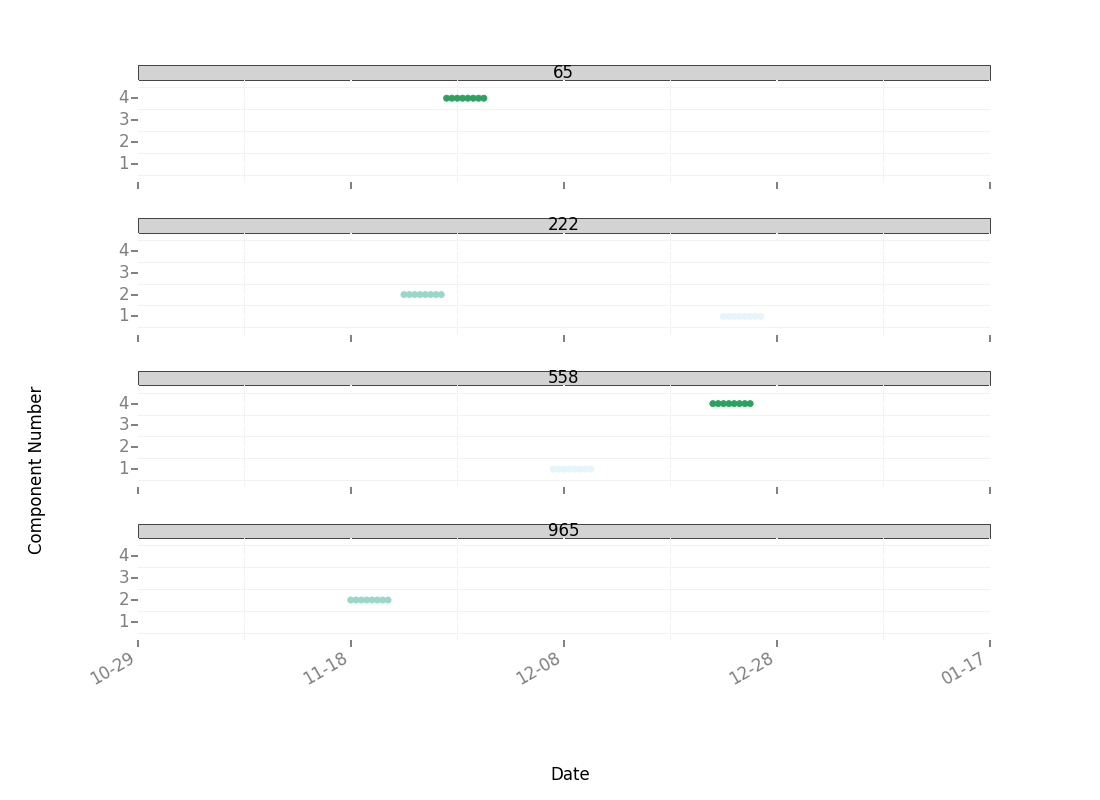

In [35]:
plt_dta = (labeled_features.filter(labeled_features.label_e > 0)
           .where(col("machineID").isin({"65", "558", "222", "965"}))
           .select(labeled_features.machineID, labeled_features.dt_truncated, labeled_features.label_e)
           .toPandas())

# format datetime field which comes in as string
plt_dta['dt_truncated'] = pd.to_datetime(plt_dta['dt_truncated'], format="%Y-%m-%d %H:%M:%S")
plt_dta.label_e = plt_dta.label_e.astype(int)

plt = ggplot(aes(x="dt_truncated", y="label_e", color="label_e"), plt_dta) +\
    geom_point()+\
    xlab("Date") + ylab("Component Number") +\
    scale_x_date(labels=date_format('%m-%d')) +\
    scale_color_brewer(type = 'seq', palette = 'BuGn') +\
    facet_grid('machineID')

display(plt)

Here we see that most of the days are marked as healthy (label = 0 are omitted for plot performance, though the dates are still accurate). Each of the four machines have multiple failures over the course of the dataset. Each labeled failure includes the date of failure and the previous seven days, all are marked with the number indicating the component that failed. 

The goal of the model will be to predict when a failure will occur and which component will fail simultaneously. This will be a multiclass classification problem, though we could pivot the data to individually predict binary failure of a component instead of a machine.

## Write the feature data to cloud storage

Write the final labeled feature data as parquet file an Azure blob storage container. For technical details, see:
https://github.com/Azure/ViennaDocs/blob/master/Documentation/UsingBlobForStorage.md

In [38]:
labeled_features.write.mode('overwrite').saveAsTable(dbutils.widgets.get("FEATURES_TABLE"))

print("Feature engineering final dataset files saved!")

# Time the notebook execution. 
# This will only make sense if you "Run All" cells
toc = time.time()
print("Full run took %.2f minutes" % ((toc - tic)/60))

Feature engineering final dataset files saved!
Full run took 4.82 minutes

# Conclusion

The next step is to build and compare machine learning models using the feature data set we have just created. The `Code\3_model_building.ipynb` notebook works through building a Decision Tree Classifier and a Random Forest Classifier using this data set.